In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('test.csv')

data

,time,open,high,low,close
0,2023-12-13T00:00:00,97.4,97.4,95.2,95.2
1,2023-12-12T00:00:00,95.4,96.8,95.3,96.8
2,2023-12-11T00:00:00,95.5,95.7,94.6,95.0
3,2023-12-08T00:00:00,94.3,95.1,93.5,94.2
4,2023-12-07T00:00:00,95.1,95.3,92.8,94.3
...,...,...,...,...,...
3475,2010-01-08T00:00:00,82.0,82.0,78.0,78.0
3476,2010-01-07T00:00:00,81.0,81.5,80.0,80.5
3477,2010-01-06T00:00:00,82.5,83.5,79.5,81.0
3478,2010-01-05T00:00:00,85.5,85.5,82.5,82.5


In [2]:
data = data[['time', 'close']]
data

,time,close
0,2023-12-13T00:00:00,95.2
1,2023-12-12T00:00:00,96.8
2,2023-12-11T00:00:00,95.0
3,2023-12-08T00:00:00,94.2
4,2023-12-07T00:00:00,94.3
...,...,...
3475,2010-01-08T00:00:00,78.0
3476,2010-01-07T00:00:00,80.5
3477,2010-01-06T00:00:00,81.0
3478,2010-01-05T00:00:00,82.5


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

C:\Users\NRH3HC\AppData\Local\Temp\ipykernel_27300\4164339735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'] = pd.to_datetime(data['time'])


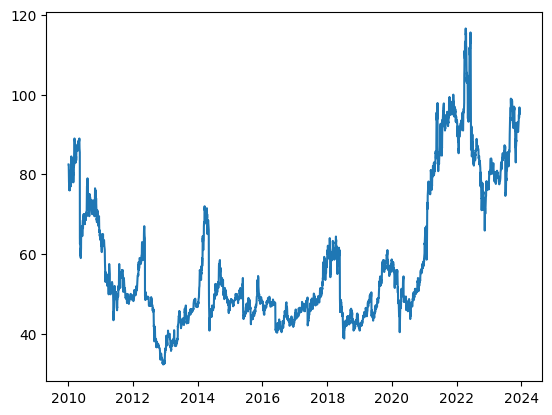

In [4]:
data['time'] = pd.to_datetime(data['time'])

plt.plot(data['time'], data['close'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('time', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
time,,,,,,,,
2023-12-04,93.6,94.8,95.0,94.3,94.2,95.0,96.8,95.2
2023-12-01,92.4,93.6,94.8,95.0,94.3,94.2,95.0,96.8
2023-11-30,91.9,92.4,93.6,94.8,95.0,94.3,94.2,95.0
2023-11-29,91.7,91.9,92.4,93.6,94.8,95.0,94.3,94.2
2023-11-28,91.1,91.7,91.9,92.4,93.6,94.8,95.0,94.3
...,...,...,...,...,...,...,...,...
2010-01-08,78.0,77.5,76.0,78.5,79.0,77.5,76.0,77.5
2010-01-07,80.5,78.0,77.5,76.0,78.5,79.0,77.5,76.0
2010-01-06,81.0,80.5,78.0,77.5,76.0,78.5,79.0,77.5


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[93.6, 94.8, 95. , ..., 95. , 96.8, 95.2],
       [92.4, 93.6, 94.8, ..., 94.2, 95. , 96.8],
       [91.9, 92.4, 93.6, ..., 94.3, 94.2, 95. ],
       ...,
       [81. , 80.5, 78. , ..., 78.5, 79. , 77.5],
       [82.5, 81. , 80.5, ..., 76. , 78.5, 79. ],
       [82.5, 82.5, 81. , ..., 77.5, 76. , 78.5]])

In [7]:
shifted_df_as_np.shape

(3473, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[0.45432977, 0.48279953, 0.48754448, ..., 0.48754448, 0.53024911,
        0.49228944],
       [0.42586002, 0.45432977, 0.48279953, ..., 0.46856465, 0.48754448,
        0.53024911],
       [0.41399763, 0.42586002, 0.45432977, ..., 0.47093713, 0.46856465,
        0.48754448],
       ...,
       [0.15539739, 0.14353499, 0.08422301, ..., 0.09608541, 0.10794781,
        0.07236062],
       [0.19098458, 0.15539739, 0.14353499, ..., 0.03677343, 0.09608541,
        0.10794781],
       [0.19098458, 0.19098458, 0.15539739, ..., 0.07236062, 0.03677343,
        0.09608541]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((3473, 7), (3473,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[0.49228944, 0.53024911, 0.48754448, ..., 0.47093713, 0.48754448,
        0.48279953],
       [0.53024911, 0.48754448, 0.46856465, ..., 0.48754448, 0.48279953,
        0.45432977],
       [0.48754448, 0.46856465, 0.47093713, ..., 0.48279953, 0.45432977,
        0.42586002],
       ...,
       [0.07236062, 0.10794781, 0.09608541, ..., 0.07236062, 0.08422301,
        0.14353499],
       [0.10794781, 0.09608541, 0.03677343, ..., 0.08422301, 0.14353499,
        0.15539739],
       [0.09608541, 0.03677343, 0.07236062, ..., 0.14353499, 0.15539739,
        0.19098458]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

3299

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3299, 7), (174, 7), (3299,), (174,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3299, 7, 1), (174, 7, 1), (3299, 1), (174, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([3299, 7, 1]),
 torch.Size([174, 7, 1]),
 torch.Size([3299, 1]),
 torch.Size([174, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.234
Batch 200, Loss: 0.130

Val Loss: 0.133
***************************************************

Epoch: 2
Batch 100, Loss: 0.063
Batch 200, Loss: 0.020

Val Loss: 0.009
***************************************************

Epoch: 3
Batch 100, Loss: 0.009
Batch 200, Loss: 0.006

Val Loss: 0.009
***************************************************

Epoch: 4
Batch 100, Loss: 0.005
Batch 200, Loss: 0.005

Val Loss: 0.008
***************************************************

Epoch: 5
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004

Val Loss: 0.007
***************************************************

Epoch: 6
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003

Val Loss: 0.007
***************************************************

Epoch: 7
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003

Val Loss: 0.006
***************************************************

Epoch: 8
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003

Val Loss: 0.006
***************************************************



tensor([[ 0.4543],
        [ 0.4259],
        [ 0.4140],
        ...,
        [-0.0581],
        [-0.0344],
        [-0.0225]])


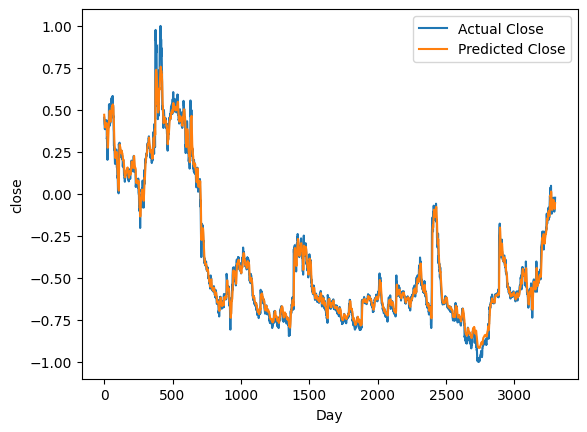

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
print(y_train)
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('close')
plt.legend()
plt.show()


In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([94.31059467, 93.93346795, 93.33802427, ..., 71.21073211,
       71.5427175 , 72.14462165])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([93.60000059, 92.39999974, 91.8999997 , ..., 71.99999998,
       73.00000007, 73.50000003])

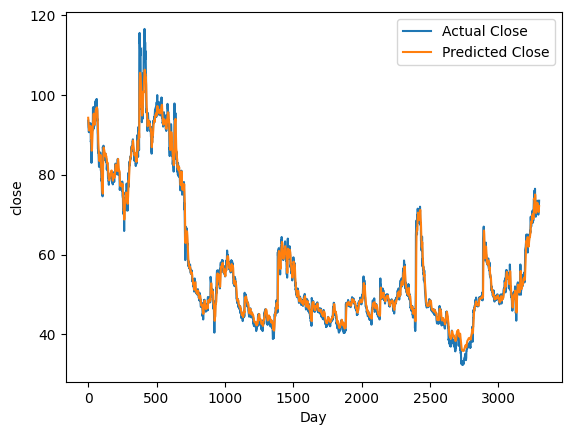

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('close')
plt.legend()
plt.show()


In [30]:
X_test

tensor([[[-0.1056],
         [-0.0937],
         [-0.0700],
         ...,
         [-0.0581],
         [-0.0344],
         [-0.0225]],

        [[-0.0937],
         [-0.0700],
         [-0.0700],
         ...,
         [-0.0344],
         [-0.0225],
         [-0.0581]],

        [[-0.0700],
         [-0.0700],
         [-0.0581],
         ...,
         [-0.0225],
         [-0.0581],
         [-0.0344]],

        ...,

        [[ 0.0724],
         [ 0.1079],
         [ 0.0961],
         ...,
         [ 0.0724],
         [ 0.0842],
         [ 0.1435]],

        [[ 0.1079],
         [ 0.0961],
         [ 0.0368],
         ...,
         [ 0.0842],
         [ 0.1435],
         [ 0.1554]],

        [[ 0.0961],
         [ 0.0368],
         [ 0.0724],
         ...,
         [ 0.1435],
         [ 0.1554],
         [ 0.1910]]])

In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([72.70107608, 72.53131723, 72.86327875, 73.01056381, 73.1136192 ,
       72.98035674, 73.26649985, 73.02558852, 73.13864457, 73.53891368,
       73.95727788, 74.42268557, 73.60942803, 72.42526793, 71.70262893,
       70.95854856, 70.60813173, 71.44950608, 72.63933244, 72.34538978,
       72.56969065, 73.64019787, 73.69891995, 72.86123748, 72.3214981 ,
       73.0186171 , 73.40752072, 74.05124081, 75.15756106, 76.63699552,
       76.35425536, 77.29048483, 77.16774529, 77.35076016, 76.47358692,
       74.60674997, 73.98705974, 72.3701209 , 71.70595463, 71.00949182,
       70.35518286, 70.1845827 , 70.1189385 , 69.85764239, 69.77413486,
       69.31019312, 69.42886644, 69.08301893, 69.07219076, 69.22497469,
       68.56238382, 68.39854058, 68.45795418, 68.25900545, 68.92627555,
       68.89828751, 69.12850539, 68.74486104, 68.73251103, 69.05472375,
       68.47369208, 69.07517541, 69.00459888, 68.44304159, 68.54093035,
       68.15368834, 67.53564369, 67.9444183 , 67.49346659, 67.10

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([71.99999998, 73.00000007, 73.00000007, 73.00000007, 72.50000003,
       73.50000003, 72.50000003, 73.00000007, 73.99999999, 74.5       ,
       75.        , 71.99999998, 70.00000013, 70.00000013, 69.50000009,
       70.00000013, 73.00000007, 75.        , 71.99999998, 72.50000003,
       75.        , 73.50000003, 70.9999999 , 70.9999999 , 73.99999999,
       73.99999999, 75.        , 76.99999993, 78.99999994, 75.49999996,
       77.99999986, 76.50000005, 76.99999993, 74.5       , 70.9999999 ,
       72.50000003, 69.50000009, 70.49999986, 70.00000013, 69.50000009,
       70.00000013, 70.00000013, 69.50000009, 69.50000009, 68.50000001,
       69.50000009, 68.50000001, 69.00000005, 69.50000009, 67.49999992,
       67.99999996, 68.50000001, 67.99999996, 70.00000013, 69.00000005,
       69.50000009, 67.99999996, 68.50000001, 69.50000009, 67.49999992,
       70.00000013, 69.00000005, 67.49999992, 68.50000001, 67.49999992,
       66.49999984, 68.50000001, 66.99999988, 66.49999984, 65.99

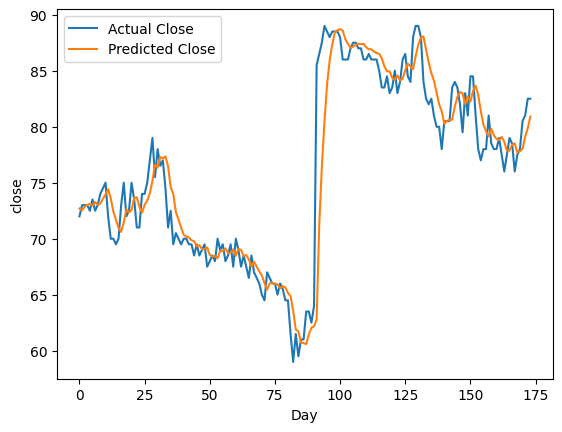

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('close')
plt.legend()
plt.show()
